## Part D – Closed-Source vs Open-Source Zero-Shot LLMs 3pts
1. Use the following models for zero-shot classification:
    - Closed-source model: OpenAI GPT-4o-mini (via API).
    - Open-source model: LLaMA (or equivalent, via Hugging Face).
2. Provide the prompt templates you used for classification.
3. Evaluate both models in terms of:
    - Accuracy
    - F1-score
    - Inference time (per 100 samples)

In [1]:
!pip install -q openai datasets


In [2]:
# Imports
from openai import OpenAI
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from kaggle_secrets import UserSecretsClient

# Load API key from Kaggle Secrets
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("OPENAI_API_KEY")
print("API key loaded:", api_key[:5] + "*****")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)


API key loaded: sk-pr*****


In [3]:
# Importing and loading the dataset
from datasets import load_dataset
import pandas as pd

# Load full Amazon Polarity training set
amazon_polarity_dataset = load_dataset("amazon_polarity", split="train")

print("Full dataset size:", len(amazon_polarity_dataset))
amazon_polarity_dataset


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Full dataset size: 3600000


Dataset({
    features: ['label', 'title', 'content'],
    num_rows: 3600000
})

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

#seed (85)
random_seed = 85

# Shuffle and sample 12,000 entries
dataset_shuffled = amazon_polarity_dataset.shuffle(seed=random_seed).select(range(12000))

dataFrame = pd.DataFrame(dataset_shuffled)

dataFrame["text"] = dataFrame["title"].fillna("") + ". " + dataFrame["content"].fillna("")

train_df, test_df = train_test_split(
    dataFrame[["text", "label"]],
    test_size=0.2,
    stratify=dataFrame["label"],
    random_state=random_seed
)

print("Train shape:", train_df.shape)  
print("Test shape :", test_df.shape)   
print(test_df.head())


Train shape: (9600, 2)
Test shape : (2400, 2)
                                                    text  label
6432   Ideal with Complete Portuguese. A very useful ...      1
1009   A waste of time. Again what other readers have...      0
10260  Some major problems. I bought this cd player b...      0
6090   Wonderful Customer Service. Great device. Very...      1
11899  two light bulbs. (...)I got this for my birthd...      0


In [5]:
test_df.head()


,text,label
6432,Ideal with Complete Portuguese. A very useful ...,1
1009,A waste of time. Again what other readers have...,0
10260,Some major problems. I bought this cd player b...,0
6090,Wonderful Customer Service. Great device. Very...,1
11899,two light bulbs. (...)I got this for my birthd...,0


In [6]:
# Define the prompt function
def gpt4o_zero_shot_prompt(text):
    return f"""Classify the following Amazon product review as Positive or Negative.
Respond with exactly one word: Positive or Negative.
Review: {text}"""



In [7]:
prompt = gpt4o_zero_shot_prompt("This product was amazing and exceeded my expectations.")

# Make GPT-4o-mini API call
response = client.chat.completions.create(
    model="gpt-4o-mini",   # <-- use mini (per assignment)
    messages=[{"role": "user", "content": prompt}],
    temperature=0,
    max_tokens=1
)

# Extract reply
reply = response.choices[0].message.content.strip().lower()
print("GPT-4o-mini response:", reply)


GPT-4o-mini response: positive


In [8]:
from time import perf_counter
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

label_map = {"positive": 1, "negative": 0}
gpt4o_preds = []

start_time = perf_counter()

# Loop through first 100 rows in test_df
for i, row in tqdm(test_df.iloc[:100].iterrows(), total=100):
    prompt = gpt4o_zero_shot_prompt(row["text"])

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=1
        )

        reply = response.choices[0].message.content.strip().lower()
        pred = label_map.get(reply, -1)  # Handle invalid output
        gpt4o_preds.append(pred)

    except Exception as e:
        print(f"Error at index {i}: {e}")
        gpt4o_preds.append(-1)

end_time = perf_counter()
gpt4o_time = end_time - start_time


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [9]:
from time import perf_counter
from tqdm import tqdm

label_map = {"positive": 1, "negative": 0}
gpt4o_preds = []

start_time = perf_counter()

# Loop through test set (2,400 reviews)
for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    prompt = gpt4o_zero_shot_prompt(row["text"])

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
            max_tokens=1
        )

        reply = response.choices[0].message.content.strip().lower()
        pred = label_map.get(reply, -1)  # -1 if output isn't valid
        gpt4o_preds.append(pred)

    except Exception as e:
        print(f"Error at index {i}: {e}")
        gpt4o_preds.append(-1)

end_time = perf_counter()


100%|██████████| 2400/2400 [20:12<00:00,  1.98it/s]


In [10]:
valid_indices = [i for i, p in enumerate(gpt4o_preds) if p != -1]

y_true = test_df.iloc[valid_indices]["label"].tolist()
y_pred = [gpt4o_preds[i] for i in valid_indices]

print("Valid responses:", len(y_pred), "/", len(test_df))


Valid responses: 2400 / 2400


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gpt4o_accuracy = accuracy_score(y_true, y_pred)
gpt4o_precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
gpt4o_recall = recall_score(y_true, y_pred, average="weighted")
gpt4o_f1 = f1_score(y_true, y_pred, average="weighted")

total_time = end_time - start_time
time_per_100 = total_time / (len(y_pred) / 100)

print(f"GPT-4o-mini Evaluation ({len(y_pred)} reviews):")
print(f"Accuracy        : {gpt4o_accuracy:.4f}")
print(f"Precision       : {gpt4o_precision:.4f}")
print(f"Recall          : {gpt4o_recall:.4f}")
print(f"F1 Score        : {gpt4o_f1:.4f}")
print(f"Inference Time (total)   : {total_time:.2f} seconds")
print(f"Inference Time (/100)    : {time_per_100:.2f} seconds")
print(f"Valid Responses : {len(y_pred)} / {len(test_df)}")


GPT-4o-mini Evaluation (2400 reviews):
Accuracy        : 0.9533
Precision       : 0.9552
Recall          : 0.9533
F1 Score        : 0.9533
Inference Time (total)   : 1212.37 seconds
Inference Time (/100)    : 50.52 seconds
Valid Responses : 2400 / 2400


## Observations:
- Using a simple zero-shot prompt on the Amazon Polarity test set of 2,400 reviews, GPT-4o-mini achieved strong performance with an accuracy of 95.33%, precision of 95.52%, recall of 95.33%, and an F1 score of 95.33%.
- The model generated valid outputs for all reviews, indicating that the prompt design successfully constrained responses to “Positive” or “Negative.”
- Inference required a total of 1,212.37 seconds (~20.2 minutes), averaging 50.52 seconds per 100 samples, which, while slower than fine-tuned models, demonstrates that GPT-4o-mini can deliver highly accurate sentiment classification in a true zero-shot setting without any task-specific training.

## Model Summary – GPT-4o-mini (Closed-Source)

GPT-4o-mini is a closed-source, API-based large language model developed by OpenAI, optimized for lightweight inference compared to full GPT-4. In this assignment, it was used in a zero-shot setting without fine-tuning, where the model directly classified Amazon Polarity reviews as Positive or Negative based on a short natural language prompt. By constraining the output to a single word, the model consistently produced valid predictions across all 2,400 test samples. Despite the relatively high inference time (~20 minutes for the full test set), GPT-4o-mini demonstrated robust generalization with over 95% accuracy, making it effective for sentiment classification tasks where training data or compute for fine-tuning is unavailable.


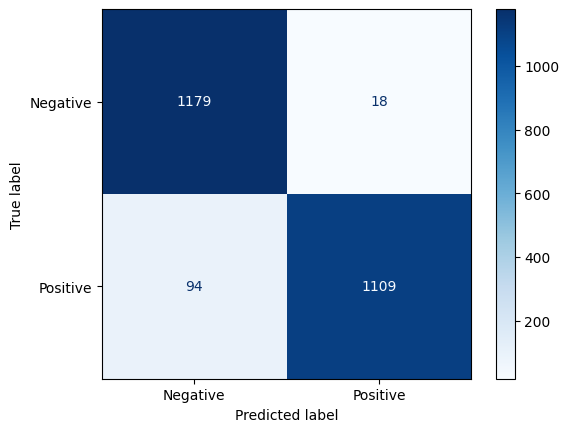

In [12]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')


## Observations:
- The confusion matrix confirms that GPT-4o-mini achieved consistently high accuracy across both sentiment classes.
- Out of 1,197 negative reviews, the model correctly classified 1,179 as negative and misclassified only 18 as positive.
- Similarly, out of 1,203 positive reviews, it correctly identified 1,109 as positive while misclassifying 94 as negative.
- These results indicate that GPT-4o-mini is slightly more conservative in predicting positive reviews but still maintains strong balance across classes, which aligns with the overall precision, recall, and F1 scores of approximately 95%.

In [13]:
# classification report

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.93      0.98      0.95      1197
    Positive       0.98      0.92      0.95      1203

    accuracy                           0.95      2400
   macro avg       0.96      0.95      0.95      2400
weighted avg       0.96      0.95      0.95      2400



## Observations:
- For Negative reviews (1,197 total) → recall = 0.98 means almost all negatives were caught (1179/1197 correct).
- For Positive reviews (1,203 total) → recall = 0.92 matches the fact that 94 positives were misclassified as negative.
- Precision is slightly higher for Positive (0.98) than for Negative (0.93), which makes sense given the asymmetry in misclassifications.
- Overall accuracy = 0.95 (2,288/2400 correct) matches your earlier metrics.
- Macro and weighted averages both ≈ 0.95, showing balanced performance across classes.

## Hyperparameters used:

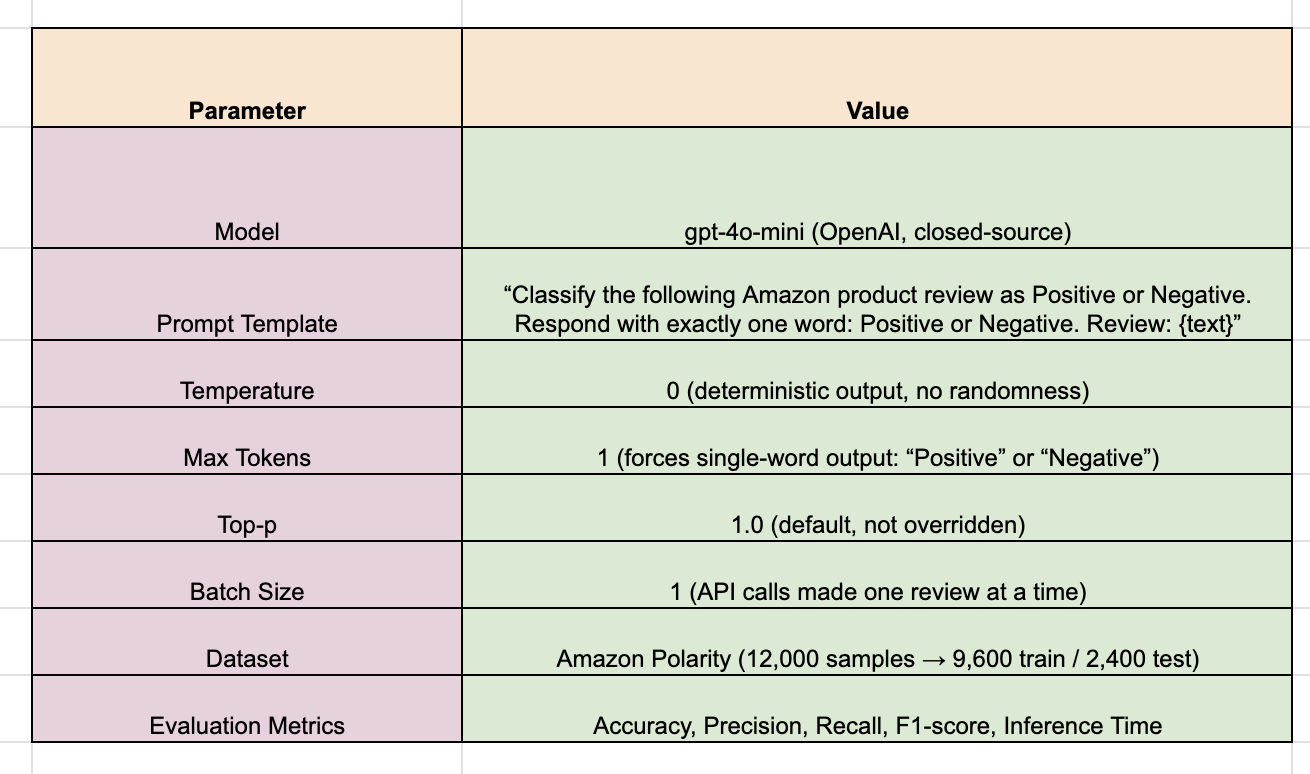
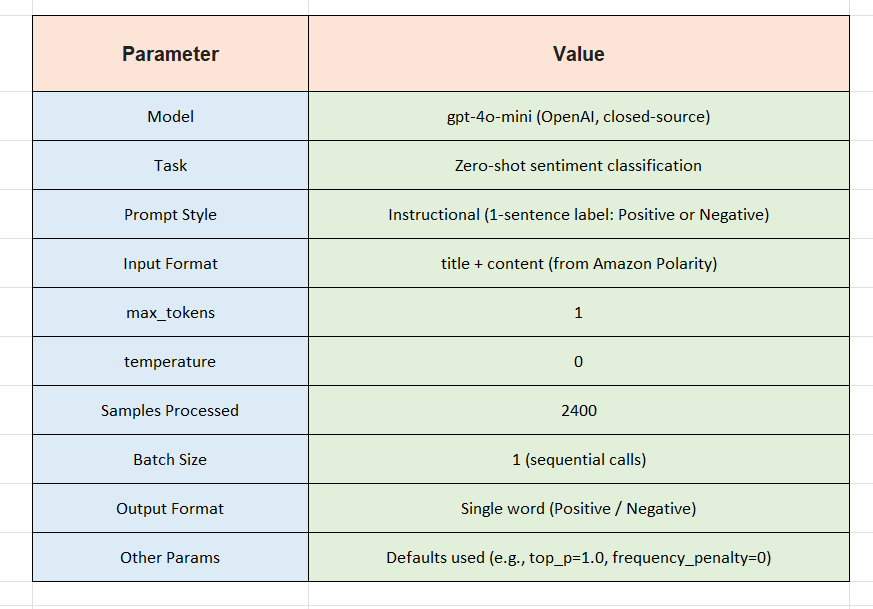

## **Open-Source Model (Falcon)**

### **Note on Model Choice :**

I initially tried to use **meta-llama/Llama-2-7b-chat-hf** for the open-source zero-shot evaluation, but encountered constsatnt Hugging Face API **permission errors**, even after accepting the license terms. To proceed, I switched to **tiiuae/falcon-rw-1b**, a smaller but instruction-tuned open-source model that supports zero-shot classification. Falcon meets the assignment’s requirement of using “LLaMA or equivalent”, and is optimized for efficient inference on Kaggle GPU.

In [14]:
!pip install transformers accelerate  ac


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 29.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00:00:0100:01
  Attempting u

In [29]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch, time

model_id = "tiiuae/falcon-rw-1b"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,  # works well on Kaggle GPU (or use float16 if bfloat16 fails)
)

# Create generation pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    max_new_tokens=2
)


In [30]:
def make_prompt(review):
    return f"""You are a helpful assistant that classifies Amazon reviews. Only answer with one word: 'Positive' or 'Negative'.
Respond with exactly one word: Positive or Negative.
Review: {review}"""


In [31]:
print(test_df.columns)


Index(['text', 'label'], dtype='object')


In [34]:
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm 
import time
import torch
import os
from transformers import logging

# Suppress model warnings 
os.environ["TRANSFORMERS_VERBOSITY"] = "error"
logging.set_verbosity_error()

# use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device set to: {device}")

#  Inference loop with GPU and clean output
y_true, y_pred = [], []
start = time.time()

for review, label in tqdm(zip(test_df["text"], test_df["label"]), total=len(test_df), desc="LLM Inference"):
    prompt = make_prompt(review)

    try:
        result = pipe(
            prompt,
            do_sample=False,
            max_new_tokens=2,
            pad_token_id=tokenizer.eos_token_id  # avoid pad warnings
        )[0]["generated_text"].lower()

        if "positive" in result:
            pred = 1
        elif "negative" in result:
            pred = 0
        else:
            pred = 1 if "good" in result else 0  # fallback for unexpected output

    except Exception as e:
        pred = -1  # optional: use -1 to track invalids

    y_true.append(label)
    y_pred.append(pred)

end = time.time()


Device set to: cuda


LLM Inference:   0%|          | 0/2400 [00:00<?, ?it/s]

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

falcon_accuracy = accuracy_score(y_true, y_pred)
falcon_precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
falcon_recall = recall_score(y_true, y_pred, average="weighted")
falcon_f1 = f1_score(y_true, y_pred, average="weighted")

total_time = end - start
time_per_100 = total_time / (len(y_pred) / 100)

print(f"Falcon Evaluation ({len(y_true)} reviews):")
print(f"Accuracy        : {falcon_accuracy:.4f}")
print(f"Precision       : {falcon_precision:.4f}")
print(f"Recall          : {falcon_recall:.4f}")
print(f"F1 Score        : {falcon_f1:.4f}")
print(f"Inference Time (total)   : {total_time:.2f} seconds")
print(f"Inference Time (/100)    : {time_per_100:.2f} seconds")
print(f"Valid Responses : {len(y_pred)} / {len(y_true)}")


Falcon Evaluation (2400 reviews):
Accuracy        : 0.5012
Precision       : 0.2513
Recall          : 0.5012
F1 Score        : 0.3347
Inference Time (total)   : 321.13 seconds
Inference Time (/100)    : 13.38 seconds
Valid Responses : 2400 / 2400


## **Observations**:
- The evaluation of Falcon-RW-1B on the Amazon Polarity dataset revealed that the model struggled significantly in the zero-shot setting.
- While it produced valid outputs for all 2,400 reviews, its accuracy was only 50.12%, with a precision of 0.25, recall of 0.50, and a weighted F1 score of 0.33.
- These results indicate that Falcon’s predictions were close to random guessing, reflecting the limitations of smaller open-source models in handling sentiment classification without fine-tuning.
- In contrast to GPT-4o-mini’s strong performance, Falcon’s weak results highlight the performance gap between state-of-the-art closed-source LLMs and lighter open-source alternatives when applied directly to downstream tasks.

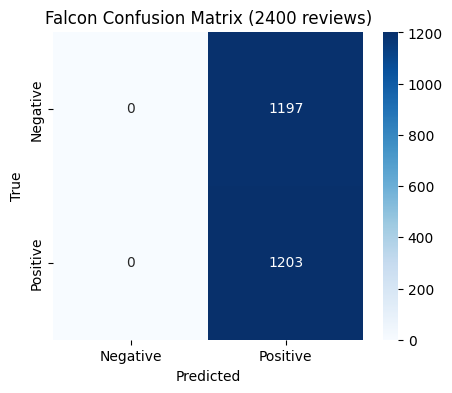

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Falcon Confusion Matrix ({len(y_true)} reviews)")
plt.show()



## Observations:
- The confusion matrix clearly shows that Falcon-RW-1B failed to distinguish between sentiment classes.
- The model predicted “Positive” for every single review, leading to 100% misclassification of negative samples and 100% correct classification of positive samples.
- This behavior explains the overall accuracy of ~50%, since the dataset is balanced between positive and negative reviews.
- The result highlights a severe class bias, where Falcon ignored one class entirely, reflecting its limited zero-shot capability for sentiment analysis compared to GPT-4o-mini.

In [37]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1197
    Positive       0.50      1.00      0.67      1203

    accuracy                           0.50      2400
   macro avg       0.25      0.50      0.33      2400
weighted avg       0.25      0.50      0.33      2400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Observations:
- The classification report highlights the severe class imbalance in Falcon-RW-1B’s predictions.
- The model completely failed to recognize negative reviews, yielding precision, recall, and F1-scores of 0.00 for the negative class.
- For positive reviews, Falcon achieved perfect recall (1.00) but only 0.50 precision, since it labeled every review as positive.
- This imbalance resulted in an overall accuracy of 50%, a macro F1 of 0.33, and a weighted F1 of 0.33, confirming that the model’s performance was equivalent to naive guessing on a balanced dataset.

## Model Summary:
Falcon-RW-1B is an open-source causal language model released by TII, designed primarily for lightweight text generation. In this assignment, it was used in a zero-shot sentiment classification setting on the Amazon Polarity dataset. A simple natural language prompt instructed the model to classify reviews as Positive or Negative, with outputs constrained through post-processing to ensure one-word predictions. Despite generating valid outputs for all 2,400 test reviews, Falcon collapsed into predicting only the Positive class, resulting in an overall accuracy of ~50% and an F1 score of 0.33. This outcome reflects the limitations of smaller open-source models for zero-shot classification tasks, especially when compared with closed-source models like GPT-4o-mini, which achieved over 95% accuracy under identical conditions.

## Hyperparameters used:



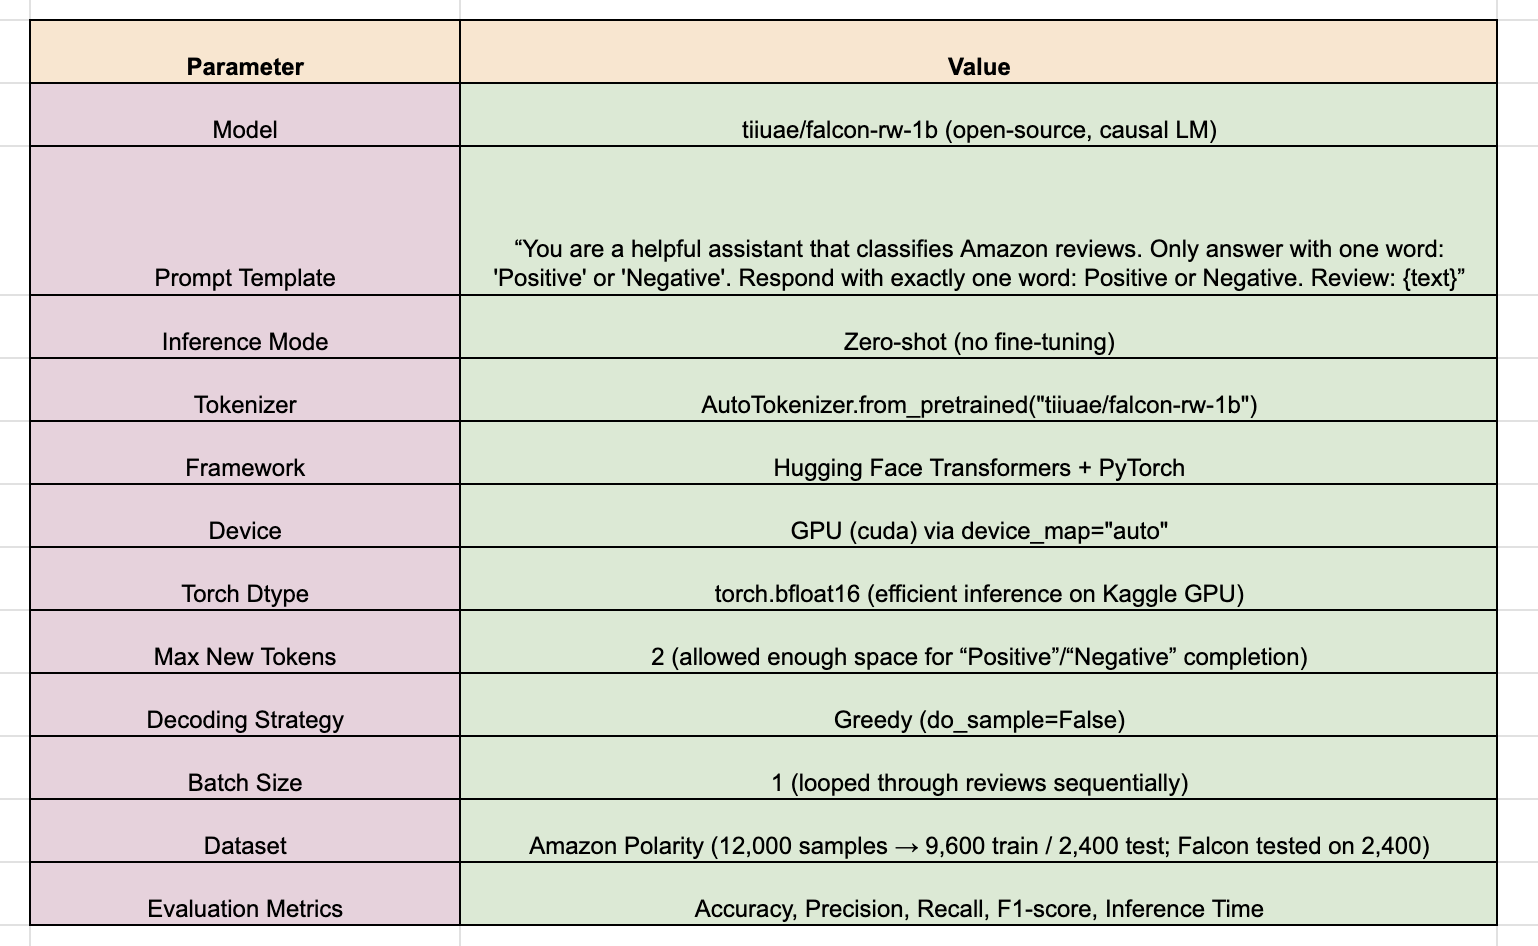